In [16]:
import scanpy as sc
import pandas as pd
import numpy as np

In [17]:
# Kinchen Human mesenchyme
adata1 = sc.read_csv('Human Colonic Mesenchyme(Kinchen., 2018)/GSE114374_Human_UC_expression_matrix.txt.gz', delimiter='\t').T

In [18]:
# Smillie Human stromal
adata2 = sc.read_mtx('Human stromal(smillie., 2019)/gene_sorted-Fib.matrix.mtx').T
genes2 = pd.read_csv('Human stromal(smillie., 2019)/Fib.genes.tsv', header=None, sep='\t')
adata2.var.index = genes2[0].values
barcodes2 = pd.read_csv('Human stromal(smillie., 2019)/Fib.barcodes2.tsv', header=None, sep='\t')
adata2.obs.index = barcodes2[0].values

In [19]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" 
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

# Raw count 확인

adata1.X.sum(axis=1)

adata2.X.sum(axis=1)

# Log1p 확인

adata1.X.max()

adata2.X.max()

# Scaling 확인

adata1.X.mean()

adata2.X.mean()

In [20]:
def preprocess_adata(adata):
    
    adata.var['mt'] = adata.var_names.str.startswith("MT-")
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    
    sc.pp.filter_cells(adata, min_genes=500)
    sc.pp.filter_genes(adata, min_cells=5)
    
    adata = adata[(adata.obs.n_genes_by_counts < 5000) &
                  (adata.obs.pct_counts_mt < 10) &
                  (adata.obs.total_counts < 50000), :]
    
    # sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    
    # adata.raw = adata.copy()

    return adata

In [21]:
adata1 = preprocess_adata(adata1)
adata1.raw = adata1.copy()

In [22]:
adata2 = preprocess_adata(adata2)
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)
adata2.raw = adata2.copy()

C:\Anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
adata1.obs['batch'] = 'kinchen'
adata2.obs['batch'] = 'smillie'

In [24]:
adata_combined = sc.concat([adata1, adata2], label='batch', keys=['kinchen', 'smillie'])

In [25]:
sc.pp.highly_variable_genes(adata_combined)

In [26]:
adata_combined.raw = adata_combined.copy()
adata_combined = adata_combined[:, adata_combined.var.highly_variable].copy()

C:\Anaconda3\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


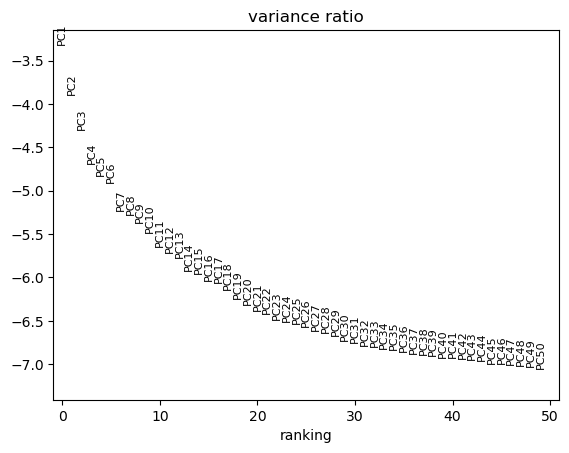

In [27]:
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_combined, log=True, n_pcs = 50)

In [28]:
# Harmony 통합
sc.external.pp.harmony_integrate(adata_combined, key="batch")

2025-07-10 14:15:52,246 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~

In [29]:
sc.pp.neighbors(adata_combined, n_neighbors=20, n_pcs=30, use_rep="X_pca_harmony")
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined, resolution=0.5)

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_22704\9590978.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.5)


In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

magma = plt.cm.get_cmap('magma', 256)
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])
new_colors = np.vstack((grey, magma_colors[20:])) 
custom_cmap1 = ListedColormap(new_colors)

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_22704\1345201060.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma', 256)


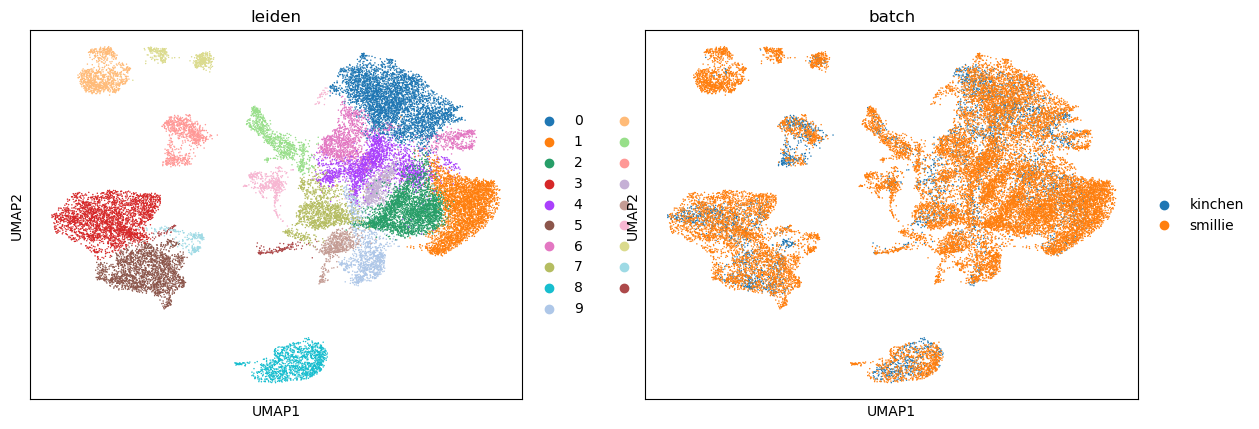

In [31]:
# 시각화
sc.pl.umap(adata_combined, color=["leiden", "batch"], use_raw=True)